In [22]:
import geopandas as gpd
import os

import xscen as xs
from xscen.config import CONFIG
import figanos.matplotlib as fg

from plot_settings import SOURCE_COLORS, DPI

fg.utils.set_mpl_style("ouranos")
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)

pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df
tdd = CONFIG["to_dataset_dict"]

2025-09-05 10:32:14 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-09-05 10:32:14 INFO     xscen.config    Updated the config with ../config_obs.yml.


In [19]:
# === Load project catalog and region shapefile ===
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

fig_path = CONFIG["paths"]["figures"]

gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
gdf["centroid_y"] = gdf.geometry.centroid.y
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()
all_regions = REGION_ORDER
HORIZON="1981-2010"

variable_mapping = {
    "pr_mean_annual_rmse": "pr_mean_annual_clim_mean",
    "pr_mean_seasonal_rmse": "pr_mean_seasonal_clim_mean",
    "tg_mean_annual_rmse": "tg_mean_annual_clim_mean",
    "tg_mean_seasonal_rmse": "tg_mean_seasonal_clim_mean"
}

def variable_mapping(v):
    return v.replace('rmse','clim_mean')

fig_path = CONFIG["paths"]["figures"]

/tmp/ipykernel_1322000/876407264.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [20]:
# === Get sorted list of variables ===
performance_pcat_df = pcat_df[pcat_df["processing_level"] == "regional_mean"]
performance_variable_groups = performance_pcat_df["variable"].unique()
performance_variables = sorted(set(item for group in performance_variable_groups for item in group))

In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import geopandas as gpd

def plot_source_winner_heatmap(
    pcat,
    performance_variables,
    variable_mapping,
    HORIZON="1981-2010",
    season_order_global=("ANNUAL","DJF","MAM","JJA","SON"),
    group_linewidth=6,
    group_linecolor="white",
    figsize_per_col=0.5,
    figsize_per_row=0.35,
    min_alpha=0.15,
    source_colors=None,  # if None, uses SOURCE_COLORS global
    subset_sources=None
):
    if source_colors is None:
        try:
            source_colors = SOURCE_COLORS
        except NameError:
            raise ValueError("SOURCE_COLORS not found; pass source_colors=...")

    # ---- 0) Region order from shapefile (ALL regions, south -> north) ----
    gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
    gdf["centroid_y"] = gdf.geometry.centroid.y
    REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()
    region_index = pd.Index(REGION_ORDER, name="region")  # fixed full list (y-sorted)

    # ---- 1) Gather per-variable data + union of sources ----
    all_sources = set()
    per_var_info = []

    for perf_var in performance_variables:
        # Performance
        perf_ds = pcat.search(processing_level="regional_mean", variable=perf_var).to_dataset()
        perf_da = perf_ds[perf_var]
        if subset_sources:
            perf_da = perf_da.sel(source=subset_sources)

        if "season" not in perf_da.dims:
            raise ValueError(f"{perf_var}: expected 'season' dim in performance.")

        # Normalize season labels (force 'ANNUAL')
        perf_seasons = []
        for s in perf_da["season"].values:
            s = str(s)
            perf_seasons.append("ANNUAL" if s.lower() == "annual" else s)
        perf_da = perf_da.sel(season=perf_da["season"]).assign_coords(season=perf_seasons)

        # Enforce stable order for this variable
        var_seasons = [s for s in season_order_global if s in perf_da["season"].values]
        var_seasons += [s for s in perf_da["season"].values if s not in var_seasons]

        all_sources.update(list(perf_da["source"].values))

        # Coherence (already reduced across source to std in your flow)
        coh_var = variable_mapping(perf_var)
        coh_ds = pcat.search(processing_level="coherence", variable=coh_var).to_dataset(**tdd)
        coh_da_all = coh_ds[coh_var]
        if "horizon" in coh_da_all.coords:
            coh_da_all = coh_da_all.sel(horizon=HORIZON)
        if "source" in coh_da_all.dims:
            coh_da_all = coh_da_all.std(dim="source")

        # Normalize coherence season labels to 'ANNUAL' if needed
        if "season" in coh_da_all.dims:
            coh_seasons = []
            for s in coh_da_all["season"].values:
                s = str(s)
                coh_seasons.append("ANNUAL" if s.lower() == "annual" else s)
            coh_da_all = coh_da_all.sel(season=coh_da_all["season"]).assign_coords(season=coh_seasons)

        # Broadcast/align coherence to this variable’s seasons
        if "season" in coh_da_all.dims:
            valid = [s for s in var_seasons if s in list(coh_da_all["season"].values)]
            if len(valid) < len(var_seasons):
                # create aligned (season, region) with NaNs for missing seasons
                parts = []
                for s in var_seasons:
                    parts.append(coh_da_all.sel(season=s) if s in valid
                                 else coh_da_all.isel(season=0, drop=True)*np.nan)
                coh_da = xr.concat(parts, dim=pd.Index(var_seasons, name="season"))
            else:
                coh_da = coh_da_all.sel(season=var_seasons)
        else:
            coh_da = coh_da_all.expand_dims(season=pd.Index(var_seasons, name="season"))

        # ---- Per-variable alpha scaling (invert-minmax) ----
        cmin = float(coh_da.min(skipna=True))
        cmax = float(coh_da.max(skipna=True))
        if not np.isfinite(cmin) or not np.isfinite(cmax) or np.isclose(cmax, cmin):
            alpha_da = xr.zeros_like(coh_da) + (1.0 - min_alpha)
        else:
            # largest coherence -> 1, smallest -> ~0 (before min_alpha clamp later)
            alpha_da = (cmax - coh_da) / (cmax - cmin)

        per_var_info.append({
            "perf_var": perf_var,
            "seasons": var_seasons,
            "perf_da": perf_da,
            "alpha_da": alpha_da,
        })

    sources = sorted(all_sources)

    # ---- 2) Build class (winner source idx) and alpha images ----
    total_cols = sum(len(info["seasons"]) for info in per_var_info)
    n_rows = len(region_index)
    class_img = np.full((n_rows, total_cols), np.nan)
    alpha_img = np.full((n_rows, total_cols), np.nan)
    col_labels, groups = [], []

    src_to_i = {s: i for i, s in enumerate(sources)}

    col0 = 0
    for info in per_var_info:
        perf_var = info["perf_var"]
        seasons = info["seasons"]
        perf_da = info["perf_da"]
        alpha_da = info["alpha_da"]

        # Reorder performance seasons (drop any missing)
        perf_da_ord = perf_da.sel(season=[s for s in seasons if s in perf_da["season"].values])

        # Winner per (region, season) — first min wins ties (idxmin default)
        win = perf_da_ord.idxmin(dim="source").reindex(region=region_index)

        for j, s in enumerate(win["season"].values):
            col_labels.append(str(s))

            # Map winners (source labels) to ints; NaN if no winner
            series = pd.Series(np.array(win.sel(season=s).values, dtype=object), index=region_index)
            mapped = series.map(src_to_i)
            class_img[:, col0 + j] = mapped.values

            # Alpha for that season; fully transparent where no data
            a = alpha_da.sel(season=s).reindex(region=region_index).to_numpy()
            # If alpha is NaN -> 0 (invisible). Else clamp with min_alpha.
            has_alpha = np.isfinite(a)
            a = np.where(has_alpha, a, 0.0)
            a = np.where(has_alpha, np.maximum(a, min_alpha), a)

            # If there is no winner in this cell -> 0 (invisible)
            no_win = ~np.isfinite(class_img[:, col0 + j])
            a = np.where(no_win, 0.0, a)

            alpha_img[:, col0 + j] = a

        groups.append((col0, col0 + len(seasons), perf_var))
        col0 += len(seasons)

    # ---- 3) Color mapping (strictly use SOURCE_COLORS) ----
    unknown = [s for s in sources if s not in source_colors]
    if unknown:
        print(f"[note] {len(unknown)} sources missing from SOURCE_COLORS: {unknown} → using '#BFBFBF'.")
    lut = np.array([source_colors.get(s, "#BFBFBF") for s in sources])
    cmap = ListedColormap(lut)

    # Build RGBA image
    rgb = np.ones((n_rows, total_cols, 3))
    valid = np.isfinite(class_img)
    if valid.any():
        rgb_idx = class_img[valid].astype(int)
        rgb_colors = cmap(rgb_idx)[:, :3]
        rgb[valid] = rgb_colors

    rgba = np.zeros((n_rows, total_cols, 4))
    rgba[..., :3] = rgb
    alpha_img = np.clip(alpha_img, 0.0, 1.0)
    rgba[..., 3] = alpha_img  # rows/cols with no data are already alpha=0

    # ---- 4) Plot ----
    fig_w = max(8, figsize_per_col * total_cols)
    fig_h = max(4.5, figsize_per_row * n_rows)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.imshow(rgba, interpolation="none", aspect="auto", origin="upper")

    ax.grid(False)

    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(region_index, fontsize=9)
    ax.set_xticks(np.arange(total_cols))
    ax.set_xticklabels(col_labels, rotation=-40, ha="left", va="top", fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("Region")

    # Group labels + white separators
    for (i0, i1, lab) in groups:
        x_center = (i0 + i1 - 1) / 2
        ax.text(x_center, -0.8, lab, ha="right", va="bottom", rotation=-20, fontsize=11)
    for (i0, i1, _) in groups[:-1]:
        ax.vlines(i1 - 0.5, -0.5, n_rows - 0.5,
                  colors=group_linecolor, linewidth=group_linewidth, zorder=5)

    # Legend
    handles = [Patch(facecolor=source_colors.get(s, "#BFBFBF"),
                     edgecolor="none", label=s) for s in sources]
    ax.legend(handles=handles, title="Source", bbox_to_anchor=(1.02, 1), loc="upper left")

    path = fig_path.format(processing_level="heatmap", horizon="1981-2010", freq="fx", file_name='_'.join(all_sources))
    dir_path = os.path.dirname(path)
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(path, dpi=DPI, bbox_inches='tight')

    plt.tight_layout()


/tmp/ipykernel_1322000/1426599011.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



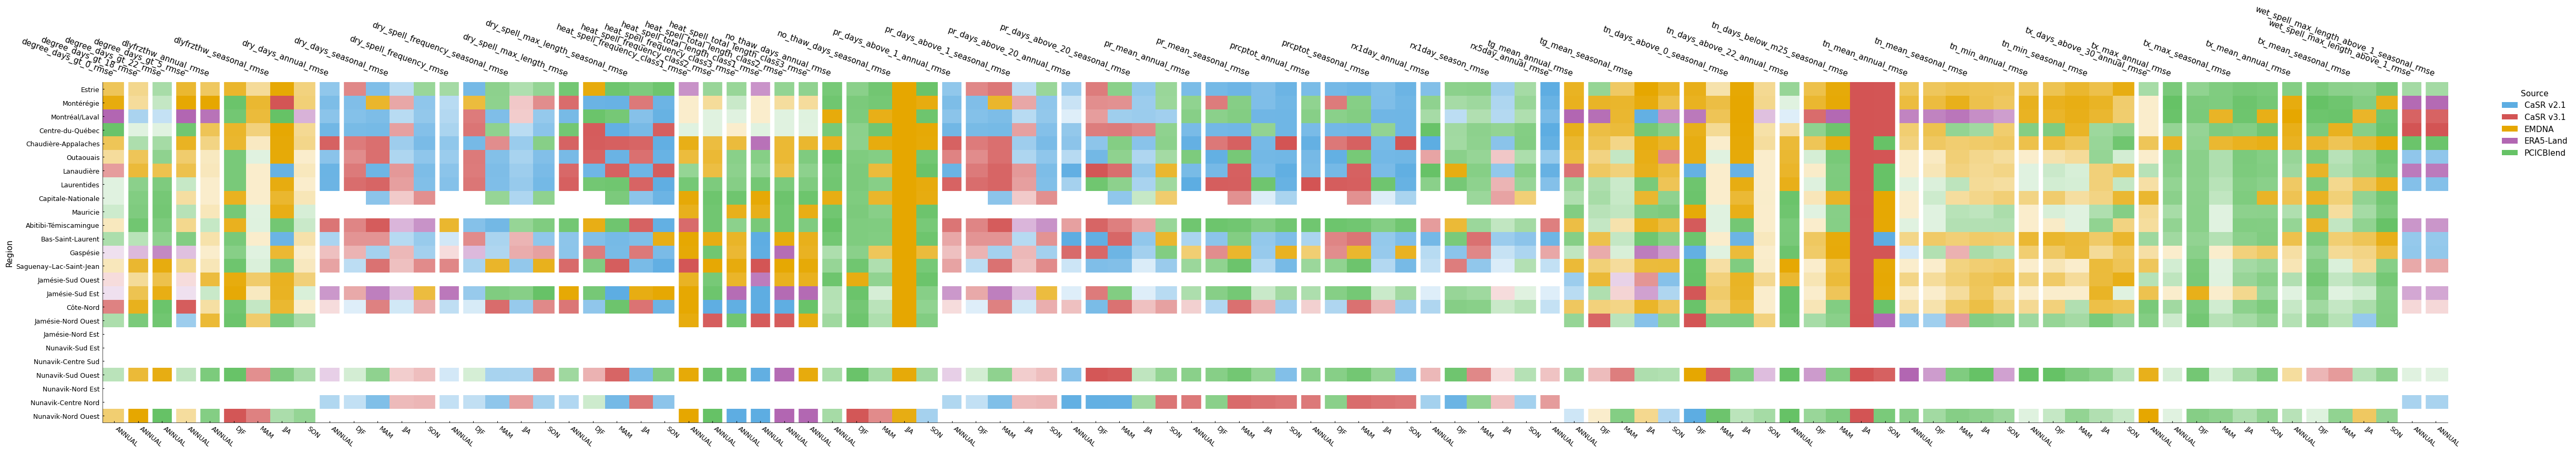

In [26]:
plot_source_winner_heatmap(
    pcat,
    performance_variables,
    variable_mapping,
    HORIZON="1981-2010",
    season_order_global=("ANNUAL","DJF","MAM","JJA","SON"),
    group_linewidth=6,
    group_linecolor="white",
    figsize_per_col=0.5,
    figsize_per_row=0.35,
    min_alpha=0.2,
    source_colors=None,  # if None, uses SOURCE_COLORS global
)

/tmp/ipykernel_4078443/4001034905.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



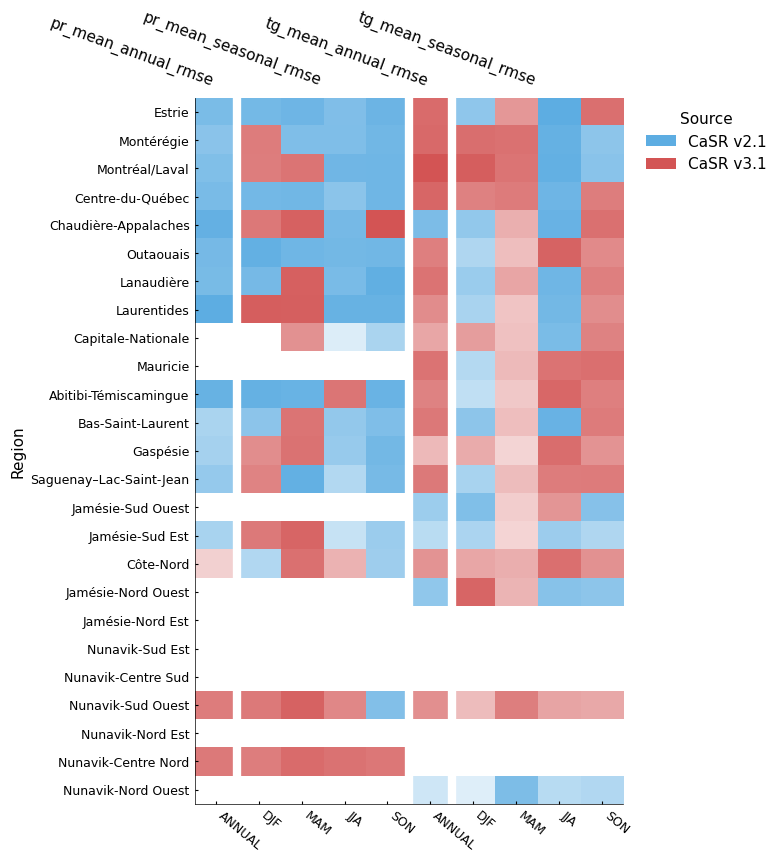

In [13]:
plot_source_winner_heatmap(
    pcat,
    performance_variables,
    variable_mapping,
    HORIZON="1981-2010",
    season_order_global=("ANNUAL","DJF","MAM","JJA","SON"),
    group_linewidth=6,
    group_linecolor="white",
    figsize_per_col=0.5,
    figsize_per_row=0.35,
    min_alpha=0.2,
    source_colors=None,  # if None, uses SOURCE_COLORS global
    subset_sources=["CaSR v3.1", "CaSR v2.1"]
)

/tmp/ipykernel_1322000/3106761535.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



degree_days_gt_0_clim_mean
degree_days_gt_18_clim_mean
degree_days_gt_22_clim_mean
degree_days_gt_5_clim_mean
dlyfrzthw_annual_clim_mean
dlyfrzthw_seasonal_clim_mean
dry_days_annual_clim_mean
dry_days_seasonal_clim_mean
dry_spell_frequency_clim_mean
dry_spell_frequency_seasonal_clim_mean
dry_spell_max_length_clim_mean
dry_spell_max_length_seasonal_clim_mean
heat_spell_frequency_class1_clim_mean
heat_spell_frequency_class2_clim_mean
heat_spell_frequency_class3_clim_mean
heat_spell_total_length_class1_clim_mean
heat_spell_total_length_class2_clim_mean
heat_spell_total_length_class3_clim_mean
no_thaw_days_annual_clim_mean
no_thaw_days_seasonal_clim_mean
pr_days_above_1_annual_clim_mean
pr_days_above_1_seasonal_clim_mean
pr_days_above_20_annual_clim_mean
pr_days_above_20_seasonal_clim_mean
pr_mean_annual_clim_mean
pr_mean_seasonal_clim_mean
prcptot_annual_clim_mean
prcptot_seasonal_clim_mean
rx1day_annual_clim_mean
rx1day_season_clim_mean
rx5day_annual_clim_mean
tg_mean_annual_clim_mean
tg

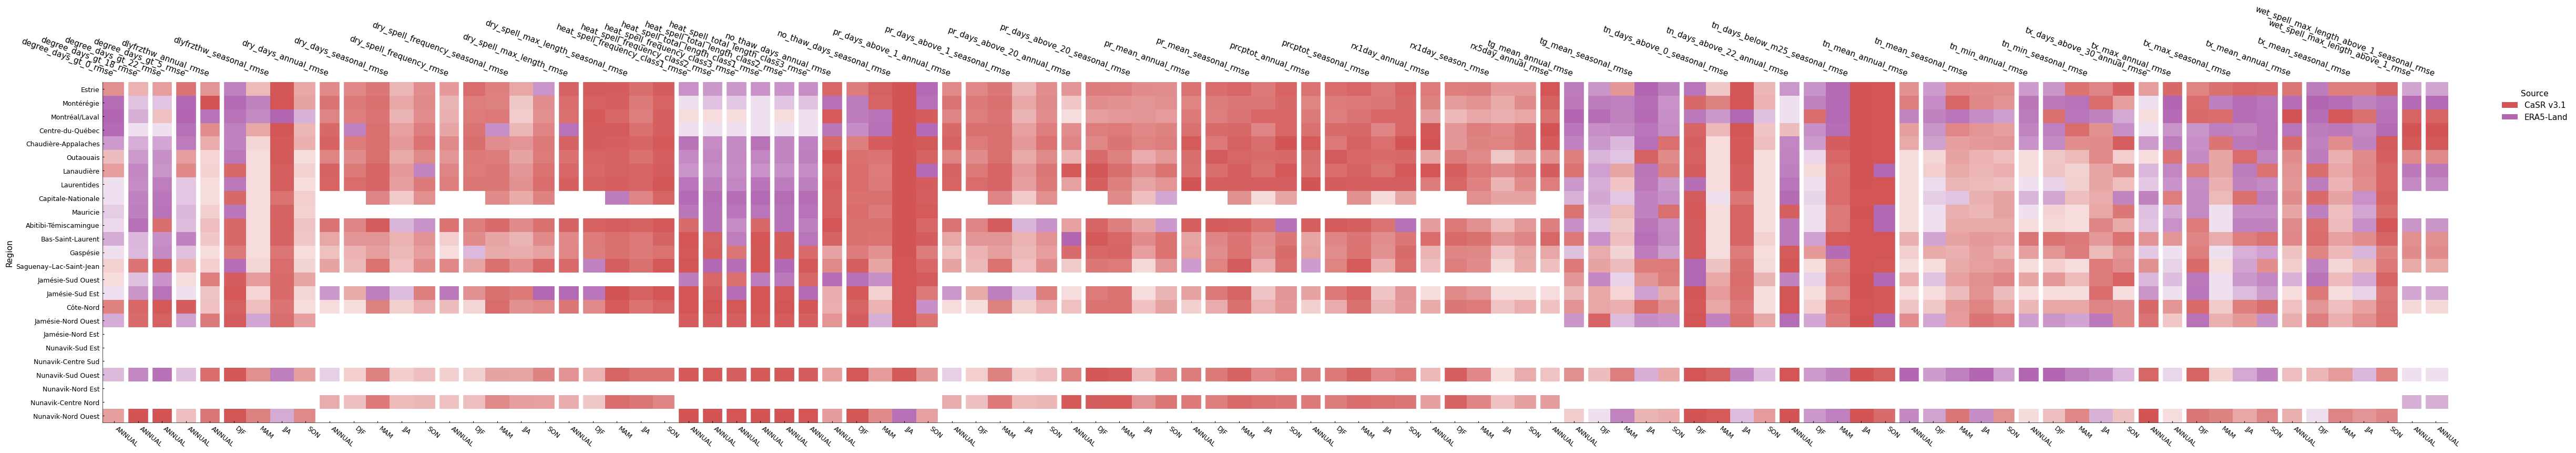

In [24]:
plot_source_winner_heatmap(
    pcat,
    performance_variables,
    variable_mapping,
    HORIZON="1981-2010",
    season_order_global=("ANNUAL","DJF","MAM","JJA","SON"),
    group_linewidth=6,
    group_linecolor="white",
    figsize_per_col=0.5,
    figsize_per_row=0.35,
    min_alpha=0.2,
    source_colors=None,  # if None, uses SOURCE_COLORS global
    subset_sources=["CaSR v3.1", "ERA5-Land"]
)